# Table of content

1.  [Overview ](#section1)

2. [Project set-up ](#section2)

3. [Exploratory Data Analysis](#section3)

4. [Text Pre-processing ](#section4)
   
   4.1. [Removing non-English reviews ](#section41) 
      
   4.2. [Creating output variable (Sentiment) from Star Rating  ](#section42) 
      
   4.3. [Creating input variables - *Bag of Words* approach ](#section43)  
        
5. [Sentiment Analysis ](#section5) 

   5.1. [Classification Tree ](#section51) 
      
   5.2. [Model Interpretation  ](#section52) 
      
   5.3. [ Model Enhancement - Cross Validation ](#section53)  
      
6. [Analysis of a Single Restaurant - The Wicked Spoon (Las Vegas Buffet) ](#section6)

     6.1. [Restaurant Selection ](#section61) 
      
     6.2. [EDA - Ratings over Time  ](#section62) 
      
     5.3. [Sentiment analysis for the Wicked Spoon ](#section63)  

<a id="section1"></a>
# Overview

## Note: The dataset has been recently updated (February 2019) to include data for 2019. I am currently working through the analysis to ensure my conclusions remain valid when adding the latest data. 


This is an analysis of the Yelp Reviews Dataset. I chose to explore reviews as I am an avid traveler and I personally I often review the places I visit. In fact, I have been rated 'helpful' on TripAdvisor which is a credential I am very proud of :)  

I was curious to explore how analytics can help businesses make decision-based on customer reviews. For this, I will make use of text analytics. 

> Text analytics **extract meaning from human language** and have the power to **offer businesses insights into large amounts of data** such as the opinions of customers; insights which can be used to **drive business decisions.**

The goals of this exercise are:
1. To assess the public perception of restaurants on Yelp via exploratory data analysis
1. To build a **machine learning model which accurately predicts the sentiment of reviews**
1. To **apply the model to a single restaurant** in order to **reveal the key aspects of that restaurant that drive overall customer perception.** 

For the machine learning model, I will build a **sentiment classifier** using **classification trees** and hopefully more complex models such as a random forest. The trained sentiment classifier can then be utilized on other online reviews which don't necessarily provide a star rating. I do *not* intend to use a sentiment lexicon, instead, I will be looking at the **review ratings** (stars) for assigning sentiment.

Additionally, I will drill down into a particular business (which will be a restaurant) and analyze the **sentiment over time**. It would be extremely interesting and highly useful if the model could tell us what caused say a drop in sentiment (e.g. if in a given period the sentiment has dropped, and in that same period the reviews are complaining about the quality of the steak, this could give the restaurant actionable insights).

Future goal: To **use the trained sentiment model to predict the sentiment of a different dataset**, such as tips data (which are short reviews and advice that do not have a star rating).


<a id="section2"></a>
# Project set-up

In [ ]:
library(rjson)
library(ggplot2)
library(zoo)

library(tm)
library(SnowballC)
library(textcat)

library(caTools)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(e1071)
library(wordcloud)

Sys.setlocale("LC_ALL", "C")

In [2]:
file_review = "../input/yelp_academic_dataset_review.json"
con = file(file_review, "r") 
input <- readLines(con, 1000000L) 
reviews <- as.data.frame(t(sapply(input,fromJSON)))
row.names(reviews) <- seq(1, nrow(reviews))

Let's start by reading in the reviews data. Each review is accompanied by a **rating from 1 to 5 starts**.

I will remove all columns from the dataset apart from the review text itself, the date, the business and the star rating which will be used to predict the positive/negative sentiment. Let's now visually inspect some of the data.

In [3]:
keeps <- c("date", "stars", "text", "business_id")
reviews = reviews[keeps]

reviews$date=as.Date.character(reviews$date, tryFormats = c("%Y-%m-%d"))
reviews$stars=as.numeric(reviews$stars)
reviews$text=as.character(reviews$text)
reviews[16:17,]

,date,stars,text,business_id
16,2017-04-07,5,"You can't really find anything wrong with this place, the pastas and pizzas are both amazing and high quality, the price is very reasonable, the owner and the staff are very friendly, if you're in downtown check this place out, a lot of people think just because it's downtown there are lots of options around but that's not always the case as there is also a lot of poor quality food in downtown as well.",YvrylyuWgbP90RgMqZQVnQ
17,2015-01-03,4,Great lunch today. Staff was very helpful in assisting with selections and knowledgeable on the ingredients. We enjoyed the BBQ chicken with tika masala sauce and really good naan bread. The biryani with chicken was also yummy! Fun to see the food being prepared in the tandoori ovens. Great addition to the fast casual scene in Cleveland.,NyLYY8q1-H3hfsTwuwLPCg


Let's now import the business dataset which contains information about the restaurants or other businesses which the reviews belong to.

In [4]:
file_business = "../input/yelp_academic_dataset_business.json"
con2 = file(file_business, "r") 
input2 <- readLines(con2, 500000L) 
business <- as.data.frame(t(sapply(input2,fromJSON)))
row.names(business) <- seq(1, nrow(business))

After importing the business dataset, I will keep only the columns of interest.

In [5]:
keeps_business <- c("business_id", "name", "city", "stars", "review_count", "categories")
business = business[keeps_business]
business[21:22,]

,business_id,name,city,stars,review_count,categories
21,dFMxzHygTy6F873843dHAA,Fremont Arcade,Las Vegas,4.5,38,"Arcades, Arts & Entertainment"
22,lxnuq9wJiwLOPJ4uZU2ljg,Las Vegas Motorcars,North Las Vegas,3.5,3,"Automotive, Car Dealers"


Furthermore, I am only interested in restaurants for my further analysis. So let's remove all other businesses.

In [6]:
business$is_restaurant = grepl("Restaurants", business$categories)
business = subset(business, is_restaurant == TRUE)
business[144:147,]
restaurant_reviews <- reviews[which(reviews$business_id %in% business$business_id),]

,business_id,name,city,stars,review_count,categories,is_restaurant
440,hXzoNgpkC86K_Jfg_zMHvA,PHO KC,Glendale,4.5,96,"Vietnamese, Restaurants",TRUE
442,EVC1vn1KQ2uETnTbDWXc5w,Cadillac Jenkins,Toronto,4.5,13,"Caribbean, Tapas/Small Plates, Restaurants",TRUE
445,4B8VnRAstRRshxiUzm9yPw,Maiko Sushi - DDO,Dollard-des-Ormeaux,4,51,"Restaurants, Sushi Bars, Japanese",TRUE
446,8ELlbjnXfZAw4KbQRP3-EQ,Tomate Basilic,Pointe-Aux-Trembles,4,8,"Italian, Restaurants",TRUE


<a id="section3"></a>
# Exploratory Data Analysis

To begin with, this is how Yelp is describing the dataset:
![Imgur](https://i.imgur.com/7cGMHB9.png)

Let's start with some **Exploratory Data Analysis.**. The first thing to note is that the **average number of reviews per business is around 68**. This will be useful later in the analysis.  

In [ ]:
mean(business$review_count)

We now want to look at is the distribution of stars.

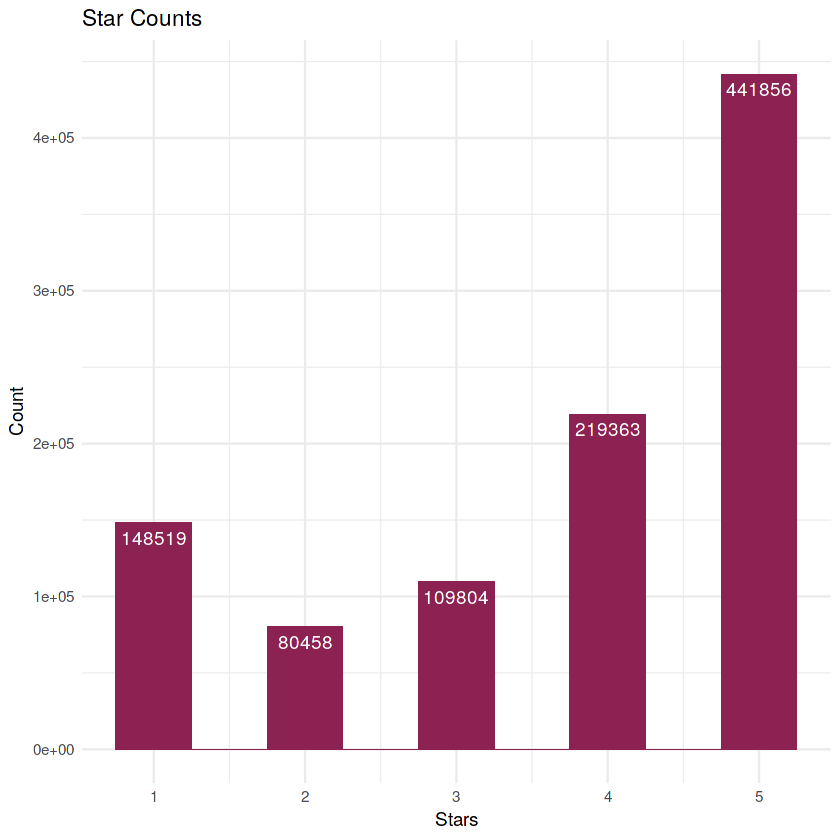

In [8]:
ggplot(reviews, aes(x=stars))+
  geom_bar(stat="bin", bins= 9, fill="violetred4") + 
  geom_text(stat='count', aes(label=..count..), vjust=1.6, color="white") +
  ggtitle("Star Counts") +
  xlab("Stars") + ylab("Count") +
  theme_minimal()

We notice that **5-star reviews are the most popular**, and also that **1-star reviews are more common than 2- or 3-star reviews.** We can assume that customers will go through the trouble of leaving a review only if they were highly impressed or highly disappointed.

<a id="section4"></a>
# Text Pre-processing 

<a id="section41"></a>
## Removing non-English reviews

To start, let's have a look at what language are the reviews written in.

In [9]:
textcat(restaurant_reviews[20:30,]$text)

[1] "english" "english" "english" "english" "english" "english" "english"
 [8] "english" "english" "english" "english"

In [10]:
restaurant_reviews = restaurant_reviews[1:50000,]
nrow(restaurant_reviews)
restaurant_reviews$language = textcat(restaurant_reviews$text)

[1] 50000

Let's have a closer look at the Language distrubution.

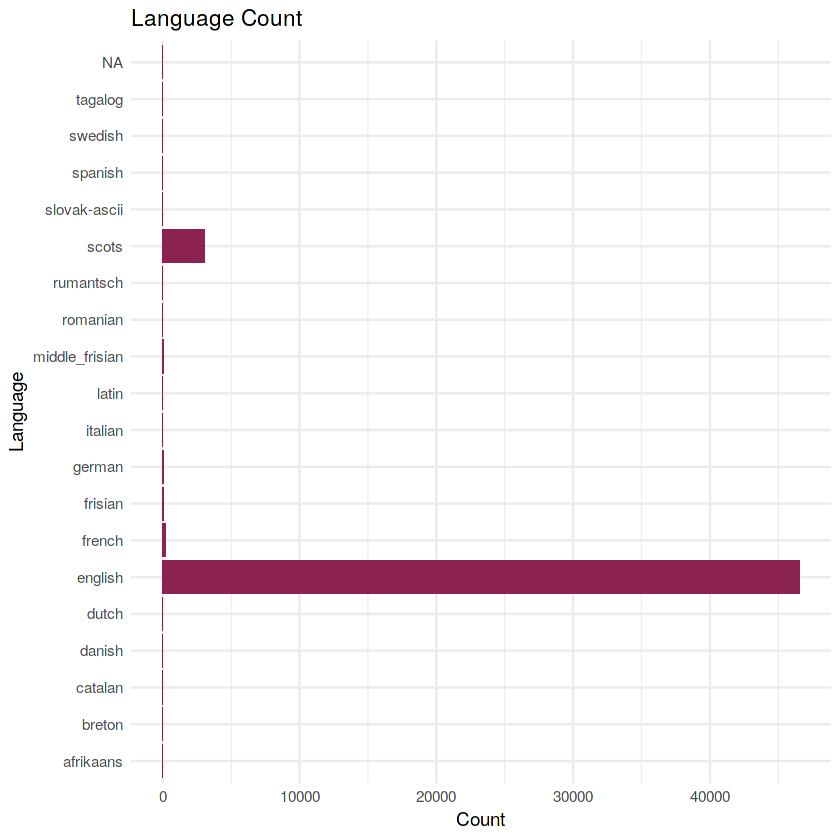

In [11]:
ggplot(restaurant_reviews, aes(x=language))+
  geom_bar(stat="count", fill="violetred4") + 
  ggtitle("Language Count") +
  xlab("Language") + ylab("Count") +
  theme_minimal() + coord_flip()

As expected, English is by far the most common. However, Scotish seems to be extremely popular too, which is unexpected. I will inspect the Scotish reviews more closely, but first let's see what a random selection of the other languages look like. 

In [12]:
foreignText = subset(restaurant_reviews, language !='english' & language !='scots')
foreignText[7:8,]

,date,stars,text,business_id,language
1000,2015-07-03,4,"Excellente place que vous passiez juste prendre un bon th<U+00E9> ou caf<U+00E9> ou que vous vouliez vous asseoir et manger un brownie d<U+00E9>cadent ou un grill cheese aux oignons caram<U+00E9>lis<U+00E9>s. Le personnel est sympathique, pas stress<U+00E9> et ne met pas de pression pour consommer. Les enfants sont les tr<U+00E8>s bienvenus et ont de quoi s occuper!!",G7sVtpD6aqpuUB4F3LEG_w,french
1168,2016-09-18,3,"Je suis all<U+00E9> <U+00E0> quelques reprises aux 3 restos Ottavio et je prends toujours les Linguines Capiccole et poires je n'avais jamais <U+00E9>t<U+00E9> d<U+00E9><U+00E7>u mais hier sur Marcel Laurin elles <U+00E9>taient ordinaires... Pour le prix 19$ , ont-ils chang<U+00E9>s la recette?",oD8kSlXINk5u7d6HQh2SxQ,french


The foreign reviews appear genuine. Let's have a look at the Scotish ones.

In [13]:
scotishText = subset(restaurant_reviews, language =='scots')
scotishText[1:2,]

,date,stars,text,business_id,language
54,2013-08-15,4,We had dinner here and the food was excellent and the service couldn't have been better! Thanks Jose! We will be back for sure.,eoyvbnRYQe-z85e8Rc6vAg,scots
73,2015-06-21,4,received a mailer and thought okay let's go. walked in on a Monday afternoon greeted by a bartender wearing a cute t shirt that said the bar and below that the baby. how cute however never got her name. looked over menu asked what was good she said the club. so ordered it and yes it is good. had a beer a club on white toast served with fries and watched sport center. really felt at ease there and good music playing. will go back again.,z9aXGRH8xtqpNDFE5_I3KA,scots


The fact that quite a few reviews are categorized as Scotish is questionable, as they are clearly in English, and the misclassification seems to be a common probelm: https://stackoverflow.com/questions/47827967/textcat-missclassification-english-reported-as-scottish .

I will remove anything other than these 2 languages.

In [14]:
restaurant_reviews = subset(restaurant_reviews, language =='english' | language =='scots')

<a id="section42"></a>
## Creating output variable (Sentiment) from Star Rating 

It would make sense to associate **4- and 5-star reviews with a positive sentiment** and **1- and 2-star reviews with a negative sentiment**.

3-star reviews would be **neutral**, but for simplicity purposes, we will only attempt to predict the positive and negative sentiment, and we will revisit neutral later. This is because our goal is to train a model to recognize positive or negative language, and 3-star reviews are likely to contain both. In normal language, neutral sentiment would mean that we are not using any words with an associated emotion, whereas this is not the case for reviews. Rather, customers assigning 3-star ratings are likely to have enjoyed some aspects and not enjoyed others. For this reason, I believe including a ''neutral' category is likely to affect our model accuracy and I would rather discard it for now. 

In [15]:
restaurant_reviews = subset(restaurant_reviews, stars != 3)

**Let's now create a binary variable for the sentiment:**

In [16]:
restaurant_reviews$positive = as.factor(restaurant_reviews$stars > 3)
table(restaurant_reviews$positive)


FALSE  TRUE 
10273 32718 

<a id="section43"></a>
## Creating input variables - *Bag of Words* approach

The following block of code processes the text by transforming it into lowercase, removing the puntuation and the common English words ( such as "this", "and" and so on).

In [17]:
corpus = VCorpus(VectorSource(restaurant_reviews$text))
corpus = tm_map(corpus, content_transformer(tolower))
corpus = tm_map(corpus, removePunctuation)
corpus = tm_map(corpus, removeWords,stopwords("english"))
corpus = tm_map(corpus, stemDocument)

Let's see how one of our reviews looks now.

In [18]:
corpus[[1]]$content

[1] "went lunch steak sandwich delici caesar salad absolut delici dress perfect amount dress distribut perfect across leaf know im go salad perfect drink price pretti good server dawn friend accommod happi summat great pub experi go"

I will now use a tecnique called **bag of words** which rearranges the data. Let's now build our Document Term Matrix. This is a processing step which involves creating a data frame where each term(i.e. each word from our reviews) is a column, and each review is a row, with corresponding values for the number of times each term appears in each review. We then remove infrequent terms and focus on the ones that appear in multiple reviews.

In [19]:
frequencies = DocumentTermMatrix(corpus)
sparse = removeSparseTerms(frequencies, 0.99)
reviewsSparse = as.data.frame(as.matrix(sparse))
colnames(reviewsSparse) = make.names(colnames(reviewsSparse))

We now add our dependent variable back and let's take a look at the result.

In [20]:
reviewsSparse$positive = restaurant_reviews$positive

<a id="section5"></a>
# Sentiment Analysis

I will start wil splitting the data into a training and testing set.

In [21]:
set.seed(174)

split = sample.split(reviewsSparse$positive, SplitRatio = 0.7)
reviewsSparse$split = split
train = subset(reviewsSparse, split==TRUE)
test = subset(reviewsSparse, split==FALSE)
#nrow(train)
#nrow(test)

We then calculate our baseline accuracy that the model will have to surpass.

In [22]:
table(train$positive)


FALSE  TRUE 
 7191 22903 

In [23]:
22903 /nrow(train)

[1] 0.7610487

**Therefore the baseline accuracy is around 76%**.
This means that more than 3 quarters of all reviews are positive. Hence the dataset is biased towards positive reviews, and the machine learning algorithm will also be more likely to predict positive reviews. There are different ways to handle this, for instance I took this into account when splitting the data into training and testing by preserving the ratio of positive to negative reviews. I could have also chosen to remove some of the positive reviews to get a more balanced dataset, however since this reflects the natural behavior of reviews, I am happy to preserve the positive bias. 

<a id="section51"></a>
## Classification Tree
I will now build a CART model (this stands for Classification and Regression Trees, in this case it will be classification). I prefer to always try this type of model before something more complex like a random forest, because it's much more interpretable and can be visualized. In this way we will be able to have a look at which words were treated as predictors.

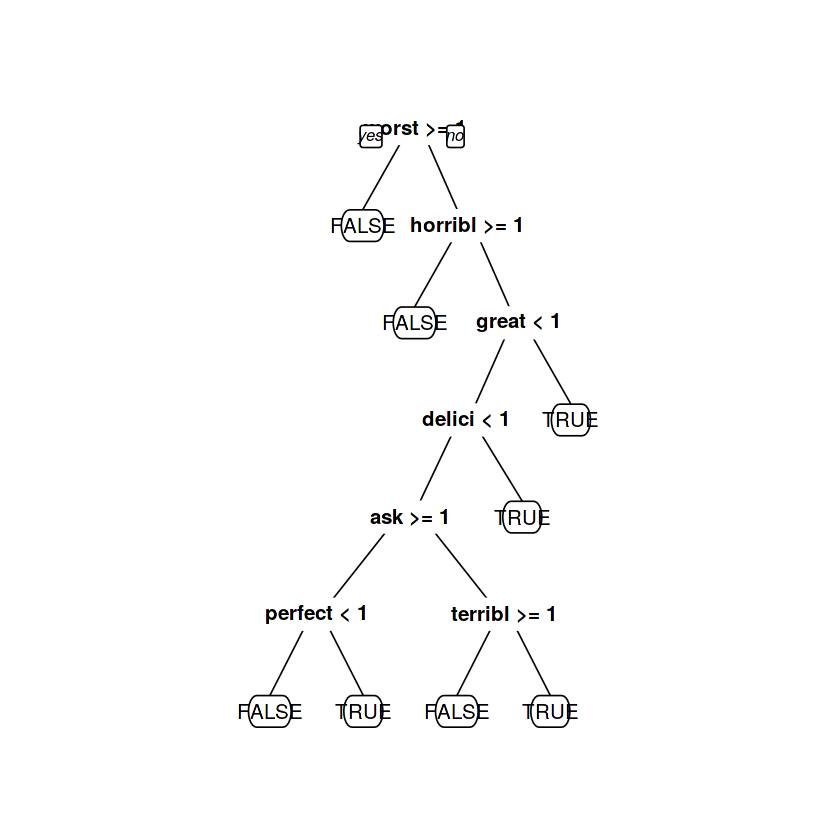

In [24]:
cartModel = rpart(positive ~ ., data=train, method="class")
prp(cartModel)

<a id="section52"></a>
## Model Interpretation
We can interpret the CART model by looking at the resulting tree. For example, if the review contains ***worst*** at least once, it will be immediately labelled as **negative**. Words such as ***great*** and  ***delicious***  lead to **positive** reviews.

Let's evaluate the performance of CART.

In [25]:
predictCART = predict(cartModel, newdata=test, type="class")
table(test$positive, predictCART)

       predictCART
        FALSE TRUE
  FALSE  1038 2044
  TRUE    251 9564

In [26]:
(1038  + 9564)/nrow(test)

[1] 0.8220516

The CART model has an 6% improvement over the baseline model which is a highly positive sign. Moreover, if we look at the tree we can easily conclude that **the words it used for its decision-making all all sentiment-related words, even though the model was not trained using a sentiment lexicon**


<a id="section53"></a>
## Model Enhancement - Cross Validation

I will now try to improve the performance by altering the default number of splits used to generate the tree. Cross validation is provided in R to help pick the optimal number of splits. There is a balance between too many splits which risks overfitting the model, and too few which may not yield a good enough accuracy. 

In [27]:
numFolds=trainControl(method = "cv", number = 10)
cpGrid = expand.grid(.cp=seq(0.001, 0.01, 0.001))
train(positive ~ ., data = train, method = "rpart", trControl = numFolds, tuneGrid = cpGrid)

CART 

30094 samples
  785 predictor
    2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 27085, 27084, 27085, 27085, 27084, 27085, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.8651225  0.6066355
  0.002  0.8599384  0.5949427
  0.003  0.8553195  0.5835438
  0.004  0.8526278  0.5767130
  0.005  0.8360492  0.4882474
  0.006  0.8257471  0.4153714
  0.007  0.8184025  0.3717256
  0.008  0.8180702  0.3711041
  0.009  0.8168075  0.3695315
  0.010  0.8168075  0.3695315

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.

The cross validation gave me the optimal parameter cp = 0.001 so I will now re-build the tree with this parameter. 

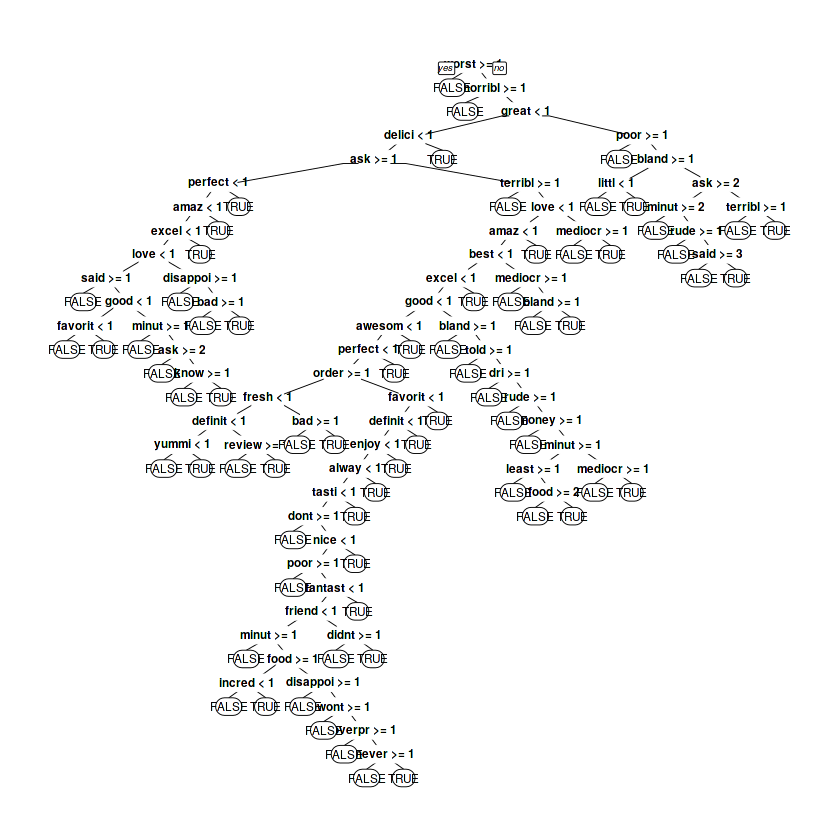

In [28]:
cartModelImproved = rpart(positive ~ ., data=train, method="class", cp= 0.001)
prp(cartModelImproved)

In this case the optimal tree has a lot of splits, which makes it more difficult to interpret, but gives us a good overview of which words are used to make the split decisions, and hence which words contribute most to the positive/negative sentiment. 

Let's now obtain predictions using the new tree. 

In [29]:
predictCARTImproved = predict(cartModelImproved, newdata=test, type="class")
table(test$positive, predictCARTImproved)

       predictCARTImproved
        FALSE TRUE
  FALSE  1789 1293
  TRUE    489 9326

In [30]:
(1789+9326)/nrow(test)   

[1] 0.8618283

**The improved model has an 86% test-set accuracy.**

This is more than 10% improvement over the baseline, and also for an NLP model this is considered very high accuracy. The main reason I am able to obtain such high accuracy from text data is because **all of the text is sentiment-related.**. This is specific to reviews data, if I was looking at something else, like sentiment from Twitter, a lot of the text would be factual, and would not express opinions. Therefore, reviews data is ideal for sentiment analysis.  

Secondly, as I am using **rating as a predictor**, this is very acurate. Some other approach like using a sentiment lexicon suffer from the intricacies of human language (e.g. humor and sarcasm can lead to positive words being used as negative and viceversa). 

<a id="section6"></a>
#  Analysis of One Restaurant - The Wicked Spoon (Las Vegas Buffet)

<a id="section61"></a>
## Restaurant Selection

Let's now have a look at the most popular businesses. 

In [31]:
business$review_count=as.numeric(business$review_count)
summary(business$review_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00    7.00   21.00   68.46   62.00 8348.00 

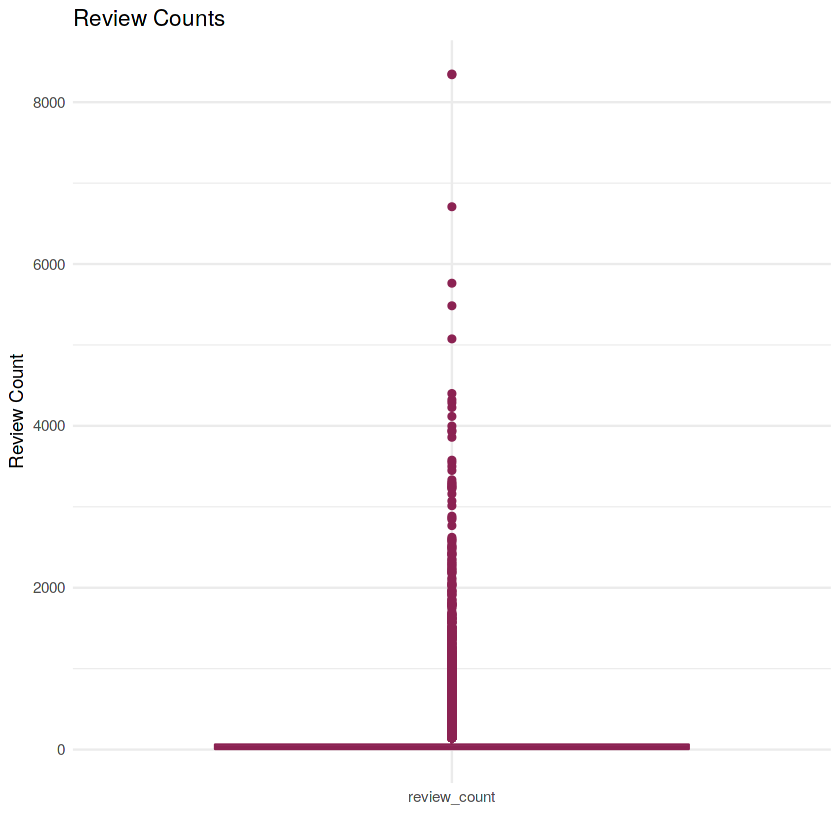

In [32]:
ggplot(business, aes(x="review_count", y=review_count))+
   geom_boxplot( col="violetred4") + 
   ggtitle("Review Counts") +
   xlab("") + ylab("Review Count") +
   theme_minimal()

It appears as though the vast majority of businesses have **under 100 reviews**, and a small number exceed 2,000 reviews. Let us consider only the businesses with 1,000 or more reviews. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


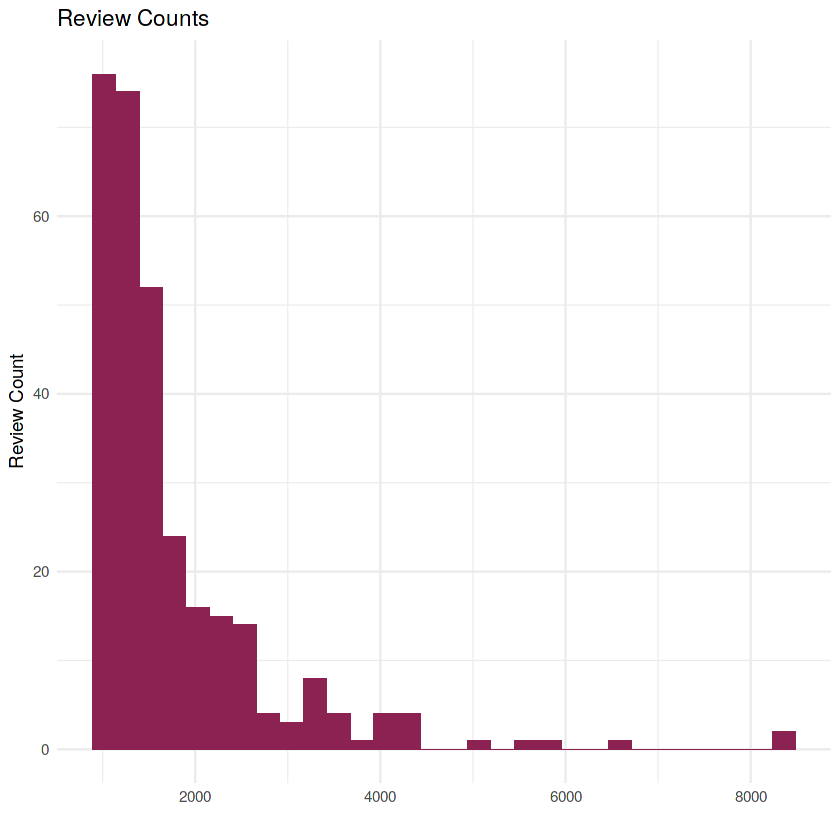

In [33]:
business_subset = subset(business, review_count > 1000)
ggplot(business_subset, aes(x=review_count))+
   geom_histogram( fill="violetred4") + 
   ggtitle("Review Counts") +
   xlab("") + ylab("Review Count") +
   theme_minimal()

In [34]:
business_top = subset(business, review_count > 5000)
business_top

,business_id,name,city,stars,review_count,categories,is_restaurant
35200,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,Las Vegas,3.5,6708,"Buffets, Breakfast & Brunch, Restaurants",TRUE
58853,f4x1YBxkLrZg652xt2KR5g,Hash House A Go Go,Las Vegas,4,5763,"Breakfast & Brunch, Food, Restaurants, American (New)",TRUE
82251,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,Las Vegas,4,8348,"Food, French, Breakfast & Brunch, Restaurants, Steakhouses",TRUE
83951,DkYS3arLOhA8si5uUEmHOw,Earl of Sandwich,Las Vegas,4.5,5075,"Food Delivery Services, Salad, Sandwiches, Soup, Food, Event Planning & Services, American (New), Restaurants, Caterers, Wraps",TRUE
89207,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,4,8339,"Restaurants, Buffets, Sandwiches, Food, Breakfast & Brunch",TRUE
141821,cYwJA2A6I12KNkm2rtXd5g,Gordon Ramsay BurGR,Las Vegas,4,5484,"Restaurants, Burgers, American (Traditional)",TRUE


As we saw previously, **most restaurants have around 70 reviews**, but we have some **very significant outliers with over 5,000 reviews.**

<a id="section62"></a>
## EDA - Ratings over Time

I will choose Wicked Spoon in Las Vegas, as it is one of the restaurants with the highest number of reviews on Yelp (6708). More interestigly, Wicked Spoon only has an overall rating of 3.5. Clearly since over 6,000 people have reviewed it, it must be a popular destination. Nonetheless, the opinions of customers seem to differ quite dramatically. Analysing these reviews more in-depth will be an interesting exercise and it will help us answer the question **If Wicked Spoon is an average-rated restaurant, why is it among the most popular?**

Before looking at sentiment, I want to inspect one business and plot the ratings over time. I will start by subsetting the dataset and sorting by date. 

In [35]:
one_business <- reviews[which(reviews$business_id=='K7lWdNUhCbcnEvI0NhGewg'),]
one_business_copy = one_business
attach(one_business_copy)
one_business <- one_business_copy[order(date),] 
detach(one_business_copy)

I would now like to see the sentiment (or rather star rating) over time. However, if I simply plot it the resulting figure is not very interpretable. What we will do instead is plot a moving average of the review ratings over time. This will offer us an insight into how the sentiment about our business has evolved over time.

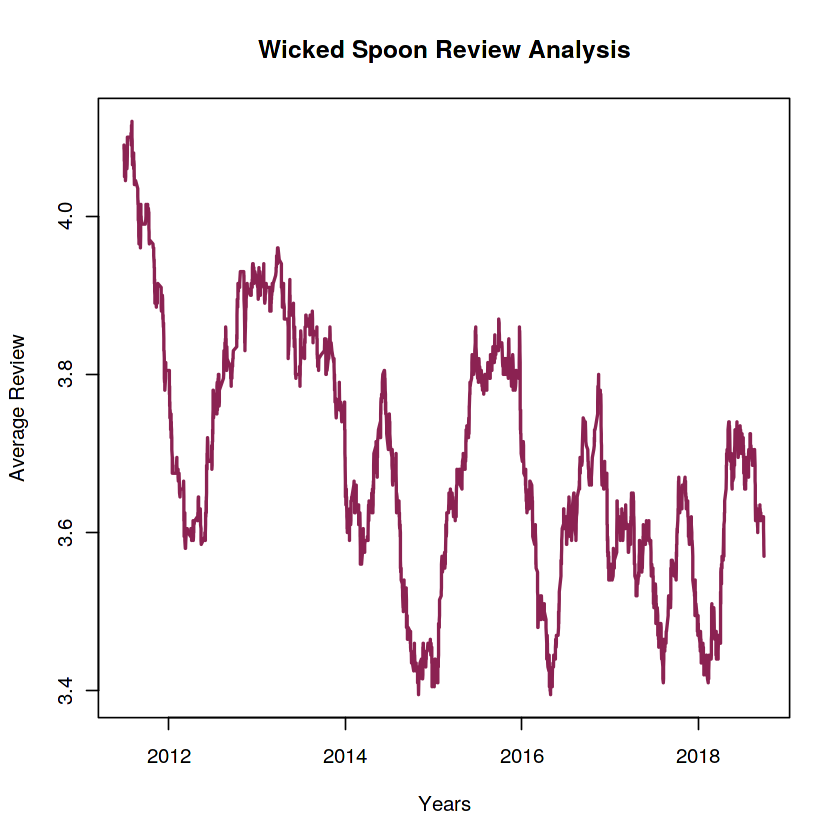

In [36]:
moving_average = rollmean(one_business$stars, 200)
moving_average_dates = one_business$date[200:3574]
plot(moving_average_dates, moving_average, type="l", xlab= "Years", ylab= "Average Review", col="violetred4" , lwd=2, main="Wicked Spoon Review Analysis")

It appears that the rating of Wicked Spoon has dropped dramatically in 2014-2015, an interesting exercise would be to understand why.

<a id="section63"></a>
## Sentiment analysis for the Wicked Spoon
The model I previsously created can be employed to gain insights into a particular business. As a restaurant owner it would be reasonable to wonder **what aspects of the services provided are viewed as negative or positive by customers. **

In [37]:
summary(one_business$stars)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   3.698   5.000   5.000 

In [38]:
one_business_copy = one_business
one_business = subset(one_business, stars !=3)
one_business$positive = as.factor(one_business$stars > 3)
corpus_one_business = VCorpus(VectorSource(one_business$text))
corpus_one_business = tm_map(corpus_one_business, content_transformer(tolower))
corpus_one_business = tm_map(corpus_one_business, removePunctuation)
corpus_one_business = tm_map(corpus_one_business, removeWords,stopwords("english"))
corpus_one_business = tm_map(corpus_one_business, stemDocument)
frequencies_one_business = DocumentTermMatrix(corpus_one_business)
sparse_one_business = removeSparseTerms(frequencies_one_business, 0.90)
reviews_sparse_one_business = as.data.frame(as.matrix(sparse_one_business))
colnames(reviews_sparse_one_business) = make.names(colnames(reviews_sparse_one_business))
reviews_sparse_one_business$positive=one_business$positive

I will now train the classification tree by **removing sentiment indicators (e.g great or worst)** which will lead to the identification of the **sentiment of specific business aspects that drive perception**.

In [39]:
names(reviews_sparse_one_business)

[1] "also"       "amaz"       "around"     "asian"      "back"      
  [6] "bar"        "best"       "better"     "bit"        "bone"      
 [11] "brunch"     "buffet"     "came"       "can"        "chees"     
 [16] "chicken"    "chocol"     "come"       "crab"       "definit"   
 [21] "delici"     "dessert"    "didnt"      "differ"     "dinner"    
 [26] "disappoint" "dish"       "dont"       "drink"      "eat"       
 [31] "enjoy"      "even"       "ever"       "everyth"    "experi"    
 [36] "favorit"    "first"      "flavor"     "food"       "fresh"     
 [41] "fri"        "friend"     "gelato"     "get"        "good"      
 [46] "got"        "great"      "high"       "item"       "ive"       
 [51] "just"       "leg"        "like"       "line"       "littl"     
 [56] "long"       "look"       "lot"        "love"       "mac"       
 [61] "made"       "make"       "mani"       "marrow"     "meat"      
 [66] "much"       "nice"       "offer"      "one"        "option"    
 [71] "peopl"      "person"     "place"      "plate"      "portion"   
 [76] "present"    "pretti"     "price"      "prime"      "qualiti"   
 [81] "realli"     "recommend"  "review"     "rib"        "salad"     
 [86] "say"        "seafood"    "select"     "serv"       "server"    
 [91] "servic"     "shrimp"     "small"      "spoon"      "station"   
 [96] "still"      "strawberri" "sure"       "sushi"      "tabl"      
[101] "tast"       "thing"      "think"      "time"       "tri"       
[106] "varieti"    "vega"       "wait"       "want"       "wasnt"     
[111] "way"        "well"       "went"       "wick"       "will"      
[116] "worth"      "positive"

In [40]:
keeps <- c( 'asian', 'bar' ,'bone', 'brunch' ,'chicken', 'chocol','crab' , 'dessert' ,'dinner','dish', 'drink','flavor',
           'food', 'fresh','gelato','leg','long' , 'marrow', 'meat','option'  ,'peopl', 'person', 'place', 'plate', 'portion',
           'price', 'prime', 'qualiti','rib', 'salad', 'seafood' ,'select', 'serv', 'server', 'servic', 'shrimp', 'small', 
           'strawberri', 'sushi', 'tabl', 'tast','time','varieti', 'wait','positive')
wicked_spoon = reviews_sparse_one_business[keeps]

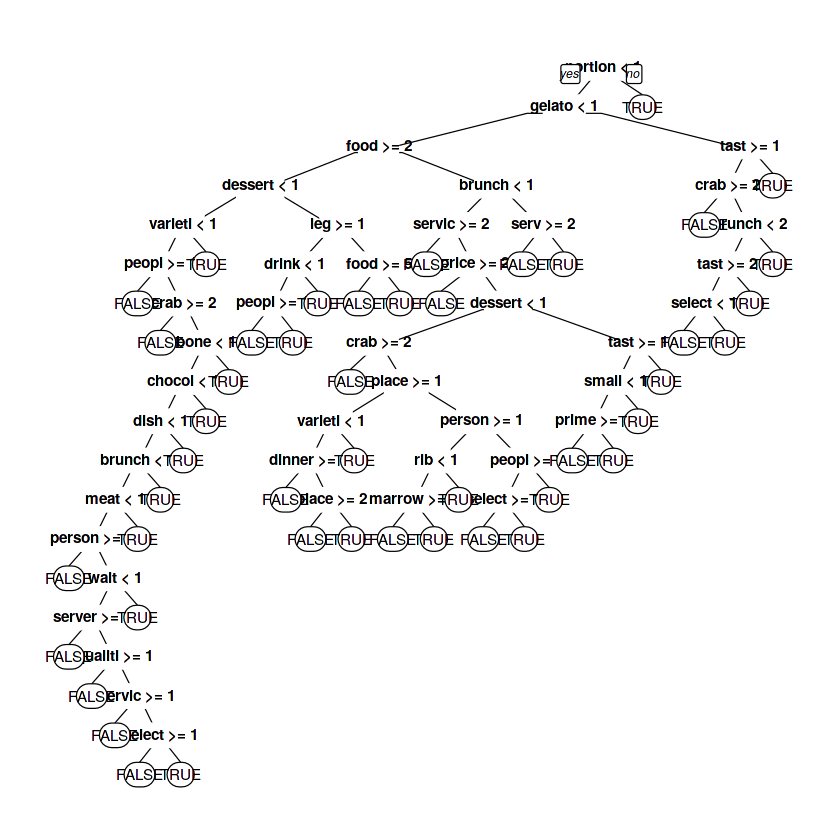

In [41]:
cartModelOneBusiness = rpart(positive ~ ., data=wicked_spoon, method="class", cp=0.002)
prp(cartModelOneBusiness)

We now have the words used to make decisions. Let's sort them by frequency and make a wordcloud.

In [42]:
top_terms = wicked_spoon
top_terms$positive = NULL
top_terms_counts = colSums (top_terms, na.rm = FALSE, dims = 1)
sort(top_terms_counts)

server      asian      peopl strawberri       long      drink    seafood 
       348        349        367        394        399        422        423 
    shrimp      prime     person     flavor       meat    portion      sushi 
       431        440        462        464        473        487        491 
     fresh        leg       tabl     option    chicken      small     chocol 
       496        513        515        524        525        533        534 
    marrow       bone        bar    varieti        rib       crab      salad 
       538        553        610        610        650        658        680 
      serv    qualiti     gelato       tast      price     dinner     servic 
       705        712        770        783        798        809        818 
     plate     brunch       wait     select       dish       time      place 
       830        878        882        991       1020       1140       1170 
   dessert       food 
      1675       3676

In [43]:
corpus_wicked_spoon = VCorpus(VectorSource(one_business_copy$text))
corpus_wicked_spoon = tm_map(corpus_wicked_spoon, content_transformer(tolower))
corpus_wicked_spoon = tm_map(corpus_wicked_spoon, removePunctuation)
corpus_wicked_spoon = tm_map(corpus_wicked_spoon, removeWords,stopwords("english"))
corpus_wicked_spoon = tm_map(corpus_wicked_spoon, removeWords,c('buffet', 'good' ,'pretty', 'spoon' ,'think', 'make','though' , 'like' ,'one','dish', 'great','can',
           'definitely', 'many','still','best','went' , 'dont', 'meat','ever'  ,'want', 'eat', 'tried', 'wicked', 'vegas',
           'got', 'sure', 'buffets','ive', 'everything', 'really' ,'came', 'things','station'  ,'try', 'love', 'around', 'much', 'better',
           'favorite', 'overall', 'bad','nice', 'will', 'just' ,'amazing', 'made', 'also','back'  ,'well', 'way', 'get', 'bit', 'lot',
           'come', 'say', 'wasnt','nice', 'will', 'just' ,'amazing','even', 'first','delicious','thing', 'desserts', 'plates', 'person', 'didnt', 'food'))

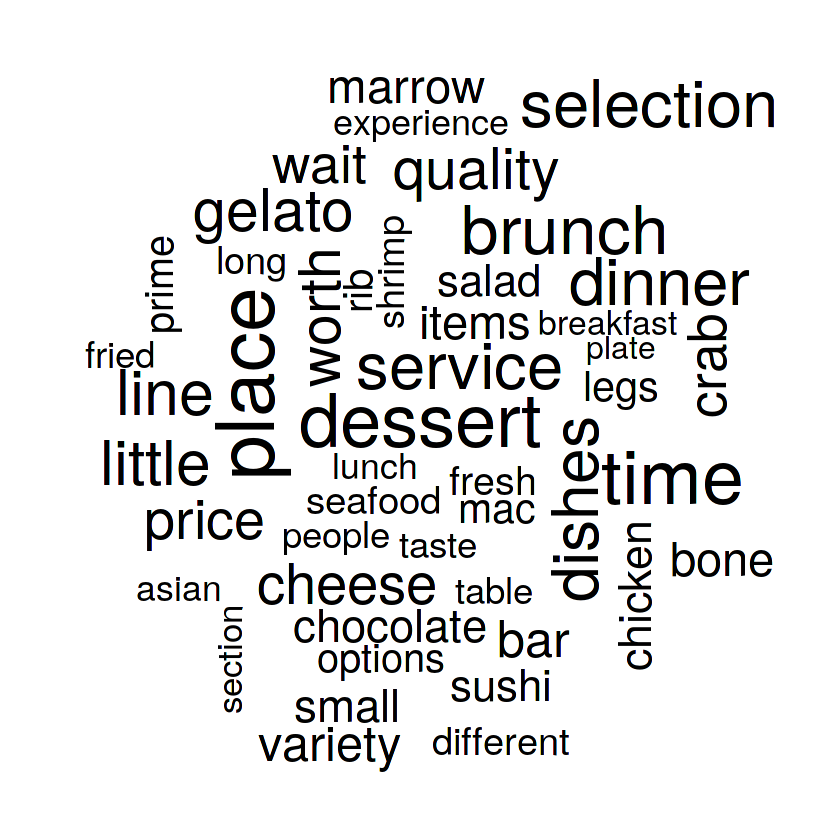

In [44]:
wordcloud(corpus_wicked_spoon, min.freq=400) 

Let us take the example of **particular words**. For example, **wait** is mentioned over 1,000 times was classified as negative, and other related words such as **long** or **time** have a similar nehative connotation.

In [45]:
sum(reviews_sparse_one_business$time)
sum(reviews_sparse_one_business$wait)

[1] 1140

[1] 882

In [46]:
reviews_sparse_one_business[reviews_sparse_one_business$wait>4,]

,also,amaz,around,asian,back,bar,best,better,bit,bone,⋯,wait,want,wasnt,way,well,went,wick,will,worth,positive
486,5,1,0,0,0,3,2,0,1,0,,5,0,0,2,1,2,1,1,1,TRUE
719,0,0,0,1,0,0,1,0,0,0,,5,0,0,0,0,0,1,1,2,FALSE
1820,1,0,0,0,0,2,1,2,0,0,,5,0,0,2,0,0,0,1,0,TRUE
1864,0,0,2,0,1,0,0,0,0,1,,5,0,0,0,1,1,0,0,0,FALSE
2528,1,0,1,1,0,0,1,3,1,3,,6,2,0,3,2,0,5,1,0,TRUE


Let's have a look at an example review which mentiones the long wait times:

In [47]:
one_business_copy[533,]

,date,stars,text,business_id
705562,2012-02-04,3,"We came here for lunch right after we landed from SFO. It was noon on December 26, 2011. The line was ridiculously long. An hour and a half wait to be exact. Actually, the wait was deceiving because upon observation, the wait time is only half of what it is actually. It turns out that after the ridiculously long line to pay, there is another line curved around the register you stand in simply to be seated. That line, which was invisible earlier, is just as long as the first line! My tip is for your party to wait in the second line while one person waits in the cashier line. This way, by the time you pay, your party is close to the front of the line to be seated:) BRILLIANT right? The food looks amazing. Most items are in cute little serving dishes so you don't have to scoop them out yourself. The variety is impressive too. There is a good mix of food from all sorts of cuisines. Sadly, when you sit down and taste the food that you have been waiting what seemed like eternity to try, it is disappointing. The dim sum is dry and the har kow has thick skin. The shrimp cocktail didn't taste that fresh. The cookies from the dessert bar were hard as rock. The experience was a serious let down:( I hear the dinner is way better. Now only if I could convince my boyfriend to give this place another try..... May be tough given so many other choices on the strip.",K7lWdNUhCbcnEvI0NhGewg


Therefore, we can clonclude that the  **long waiting time relates to the poor rating of this restaurant. **

Fially let's look at trends in these words over time. 

In [48]:
one_business_date = subset(one_business_copy, date>'2014-01-01'&date<'2016-01-01')
corpus_one_business_date = VCorpus(VectorSource(one_business_date$text))
corpus_one_business_date = tm_map(corpus_one_business_date, content_transformer(tolower))
corpus_one_business_date = tm_map(corpus_one_business_date, removePunctuation)
corpus_one_business_date = tm_map(corpus_one_business_date, removeWords,stopwords("english"))
corpus_one_business_date = tm_map(corpus_one_business_date, stemDocument)
frequencies_one_business_date = DocumentTermMatrix(corpus_one_business_date)
sparse_one_business_date = removeSparseTerms(frequencies_one_business_date, 0.90)
reviews_sparse_one_business_date = as.data.frame(as.matrix(sparse_one_business_date))
colnames(reviews_sparse_one_business_date) = make.names(colnames(reviews_sparse_one_business_date))

In [49]:
sum(reviews_sparse_one_business_date$time)
sum(reviews_sparse_one_business_date$wait)

[1] 379

[1] 274

Almost 400 of mentions being in 2014-15 when the sentiment dropped 


In [50]:
dtm <- DocumentTermMatrix(corpus_wicked_spoon)
dtm.matrix <- as.matrix(dtm)
wordcount <- colSums(dtm.matrix)
toptwenty <- head(sort(wordcount, decreasing=TRUE), 20)